# Clustering of disease node embedding vectors

In previous steps of the workflow we:
 * Constructed an ontology enriched rare disease focused knowledge graph
 * Performed random walks originating at each rare disease node
 * Used those random walks as corpuses for fitting word2vec vector embedding models
 
The next step is to use the embedding vectors for the disease nodes as features in unuspervised clustering models. The purpose of this notebook is to illustrate our approach to clustering and do some light visual analysis of the results.

In [1]:
import pickle
from collections import Counter
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

from sklearn import cluster
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, Normalizer
import umap

import networkx as nx
from kneed import KneeLocator
import gensim

%matplotlib inline

## Load the knowledge graph

In [2]:
with open('../data/processed/disease_ontograph.pkl', 'rb') as f:
    disease_ontograph = pickle.load(f)

#Remove unconnected components
components = [i for i in nx.connected_components(disease_ontograph)]
disease_ontograph = disease_ontograph.subgraph(components[0]).copy()

#Extract diseases
diseases = [n for n in disease_ontograph.nodes if disease_ontograph.nodes[n].get('label') ==  'disease']

## Load the embedding model

In [3]:
model = gensim.models.Word2Vec.load("../data/embeddings/ontograph_embed_N250_L250_D32_K20.model")

#obtain the disease vectors
disease_vectors = model.wv[diseases]

## K-means clustering

K-means clustering is a reasonable first unsupervised model to test. However, it is non-parametric and we therefore need to determine the number of clusters using internal criteria. We use the elbow method to that. 


In [12]:
inertia_scores = []
k_values = [i for i in range(2,200)]

#Standardize because we pulled the disease vectors out from full embedding model
standard_vectors = StandardScaler().fit_transform(disease_vectors)

#Normalize because magnitude of embedding vector corresponds to frequency. We care about context, which is reflected in the direction of the vector
normalized_vectors = Normalizer().fit_transform(standard_vectors)


In [5]:

for k in k_values:
    model = cluster.KMeans(n_clusters=k)
    model.fit(normalized_vectors)
    inertia_scores.append(model.inertia_)

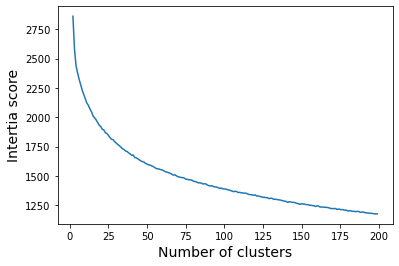

In [6]:
plt.plot(k_values,inertia_scores)
plt.xlabel('Number of clusters',size=14)
plt.ylabel('Intertia score',size=14)
plt.show()

### Automate the elbow finding with the Kneed package

37

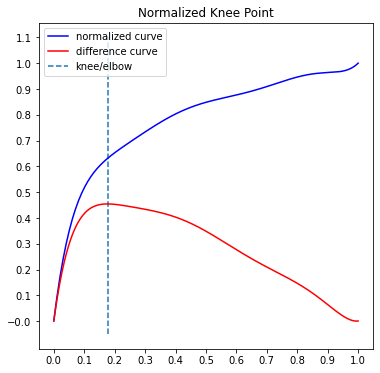

In [7]:
kl = KneeLocator(x=k_values, 
                 y=inertia_scores, 
                 curve='convex', 
                 direction='decreasing', 
                 interp_method='polynomial',
                 S=1)
    
kl.plot_knee_normalized()
kl.knee

### Fit the final k-means model with 35 clusters, as per the elbow finding algorithm

In [4]:
with open('../data/clusters/kmeans/ontograph_embed_N250_L250_D32_K20_KMEANS_KOPT37.pkl', 'rb') as f:
    kmeans = pickle.load(f)
#kmeans = cluster.KMeans(n_clusters=37,random_state=0)
#kmeans.fit(normalized_vectors)

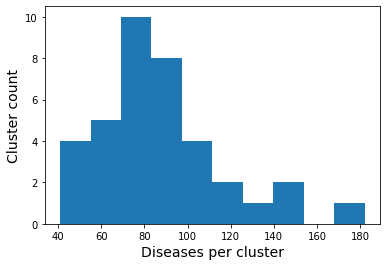

In [5]:
#Distribution of diseases per cluster
cluster_labels= kmeans.labels_
cluster_count = Counter(kmeans.labels_)
cluster_dist = Counter(sorted(cluster_count.values(),reverse=True))
clust, cnt = zip(*cluster_dist.items())

plt.hist(cluster_count.values()) 
plt.ylabel('Cluster count',size=14)
plt.xlabel('Diseases per cluster',size=14)
plt.show()


In [10]:
np.mean(list(cluster_count.values()))

87.62162162162163

### Visualization with t-SNE

t-SNE is a manifold learning based dimensionality reduction method. I will use it to project my embedding vectors down into a 2 dimensional space and overlay the cluster assignment labels to see the clustering. This is a loose non-quantitative visual inspection of the cluster quality

In [13]:
transform = TSNE
trans = transform(n_components=2,early_exaggeration=10)
node_embeddings_2d = trans.fit_transform(normalized_vectors)

/Users/sanjakjs/opt/anaconda3/envs/rdclust/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/sanjakjs/opt/anaconda3/envs/rdclust/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


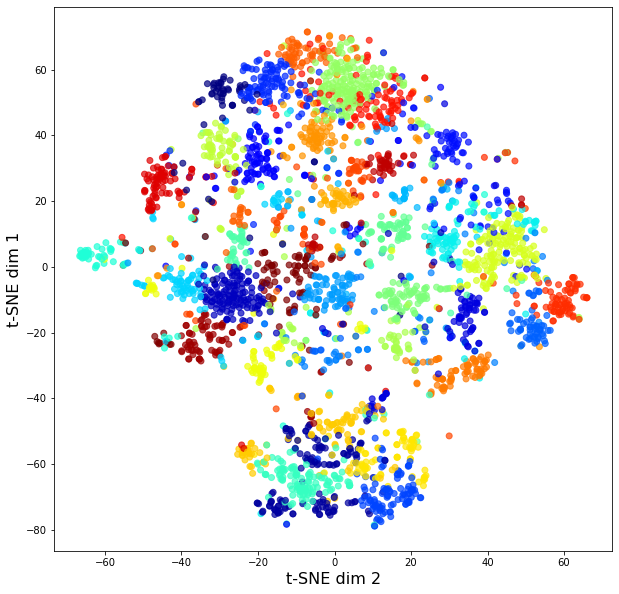

In [25]:
# draw the embedding points, coloring them by the target label (paper subject)
alpha = 0.7
#label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
#node_colours = [label_map[target] for target in node_targets]

plt.figure(figsize=(10,10), facecolor='white', edgecolor='k')
#plt.axes().set(aspect="equal")
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=cluster_labels,
    cmap="jet",
    alpha=alpha,
)
#plt.grid(b=None)
plt.xlabel("t-SNE dim 2",size=16)
plt.ylabel("t-SNE dim 1",size=16)
#plt.title("t-SNE visualization of disease embeddings".format(transform.__name__),size=20)
plt.show()

### Comparison of randomly sorted vs cluster sorted embedding vector heatmap

Another approach to visual inspection of the cluster quality is to plat the vector embedding values as a heatmap, sorted by cluster assignment. If the clusters are coherent, then similar embedding vectors will group together and this will reveal itself as patterns in the heatmap. For a point of comparison, I will plot this heatmap next to same values randomly sorted.

In [21]:
sorted_labels = cluster_labels[np.argsort(cluster_labels)]

# Get cluster demaractions for enhancing visual
hlines=[]
for i in set(sorted_labels):
    if i > 0:
        hlines.append(list(sorted_labels).index(i))
        
random_order = [i for i in range(len(disease_vectors))]
random.shuffle(random_order)


In [22]:
cluster_map = {dis:kmeans.labels_[i] for i,dis in enumerate(diseases)}

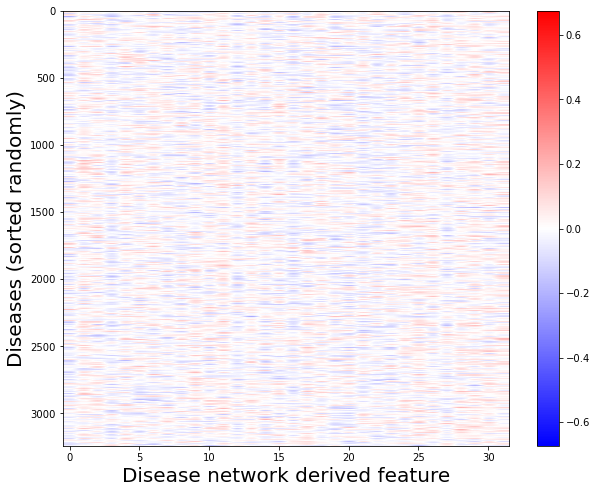

In [27]:
fig = plt.figure(figsize=(10,8), facecolor='w', edgecolor='k')
plt.imshow(normalized_vectors[random_order],aspect='auto',cmap='bwr')
#plt.title("Randomized embeddings",size=20)
#plt.title("Cluster sorted diseases",size=20)
plt.ylabel('Diseases (sorted randomly)',size=20)
plt.xlabel('Disease network derived feature',size=20)

# setup the colorbar
normalize = mcolors.Normalize(vmin=normalized_vectors.min(), vmax=normalized_vectors.max())
colormap = cm.bwr

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(normalized_vectors)
plt.colorbar(scalarmappaple)

plt.show()

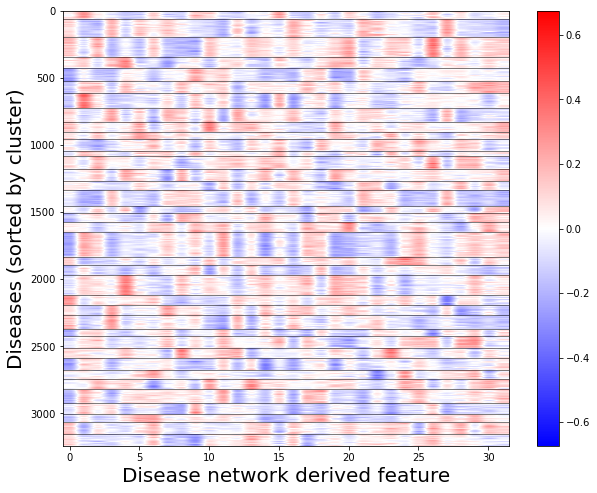

In [24]:
fig = plt.figure(figsize=(10,8), facecolor='w', edgecolor='k')
plt.imshow(normalized_vectors[np.argsort(cluster_labels)],aspect='auto',cmap='bwr',label="Normalized embedding value")
for i in hlines:
    plt.axhline(y=i, color='black', linestyle='-',lw=.5)
#plt.title("Cluster sorted diseases",size=20)
plt.ylabel('Diseases (sorted by cluster)',size=20)
plt.xlabel('Disease network derived feature',size=20)

# setup the colorbar
normalize = mcolors.Normalize(vmin=normalized_vectors.min(), vmax=normalized_vectors.max())
colormap = cm.bwr

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(normalized_vectors)
plt.colorbar(scalarmappaple)

plt.show()

## Drug connections

In [ ]:
TCRD_drugs = pd.read_table("../data/raw/TCRDv6.12.4.tsv")
TCRD_drugs = TCRD_drugs[TCRD_drugs['NCBI Gene ID']!='None']
TCRD_drugs['NCBI Gene ID'] = TCRD_drugs['NCBI Gene ID'].astype('int')
gard_gene_data_drugs = gard_gene_data.merge(TCRD_drugs,'left',left_on='Gene_ID',right_on='NCBI Gene ID')

In [26]:
TCRD_drugs

,TCRD ID,Name,Description,HGNC Symbol,UniProt,NCBI Gene ID,STRING ID,TDL,IDG Eligible
0,1,CGL_HUMAN,Cystathionine gamma-lyase,CTH,P32929,1491,ENSP00000359976,Tchem,0
1,2,CG077_HUMAN,Uncharacterized protein C7orf77,C7orf77,A4D0Y5,154872,ENSP00000480627,Tdark,0
2,3,CH034_HUMAN,Uncharacterized protein C8orf34,C8orf34,Q49A92,116328,ENSP00000427820,Tdark,0
3,4,CGBP1_HUMAN,CGG triplet repeat-binding protein 1,CGGBP1,Q9UFW8,8545,ENSP00000381429,Tbio,0
4,5,CH076_HUMAN,Uncharacterized protein C8orf76,C8orf76,Q96K31,84933,ENSP00000276704,Tdark,0
...,...,...,...,...,...,...,...,...,...
20407,20408,MTR1B_HUMAN,Melatonin receptor type 1B,MTNR1B,P49286,4544,ENSP00000257068,Tclin,0
20408,20409,MXRA7_HUMAN,Matrix-remodeling-associated protein 7,MXRA7,P84157,439921,ENSP00000348050,Tdark,0
20409,20410,MLXPL_HUMAN,Carbohydrate-responsive element-binding protein,MLXIPL,Q9NP71,51085,ENSP00000320886,Tbio,0
20410,20411,MND1_HUMAN,Meiotic nuclear division protein 1 homolog,MND1,Q9BWT6,84057,ENSP00000240488,Tbio,0


In [23]:
gard_gene_data_drugs['Cluster'] = [cluster_map[i] for i in gard_gene_data_drugs['GARD_ID']]

In [24]:
cluster_drugs = gard_gene_data_drugs[gard_gene_data_drugs.TDL == 'Tclin']
cluster_tclin_counts = cluster_drugs[['Cluster','GARD_ID','Gene_ID','TDL']].drop_duplicates().Cluster.value_counts()

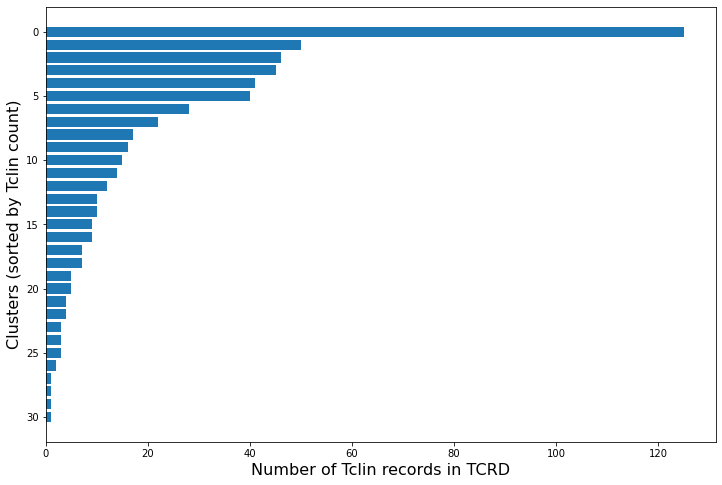

In [25]:
fig = plt.figure(figsize=(12,8), facecolor='white', edgecolor='k')

# Example data
ax = fig.add_subplot()
y_pos = np.arange(len(cluster_tclin_counts.index))
ax.barh(y_pos, cluster_tclin_counts.values, align='center')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Number of Tclin records in TCRD',size=16)
ax.set_ylabel('Clusters (sorted by Tclin count)',size=16)
plt.show()